In [160]:
import warnings
warnings.filterwarnings('ignore')

# Activity and Sleep
In this notebook we focus on the Fitbit activity data as a means to unearth some questions about the self-report sleep metrics from Beiwe

In [161]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats import linregress

# Table of Contents
1. [Data Import](#data_import)
    1. [Target Data: Fitbit Sleep](#targets)
    2. [Feature Data: Fitbit Activity](#features)
2. [Pre-Processing](#preprocessing)
    1. [Target Data](#target_data)
        1. Summary
        1. Scaling
    2. [Feature Data](#feature_data)
3. [Analyzing Relationships](#analysis)

In [162]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='data_import'></a>

# Data Import
Data are simply imported from the Fitbit daily dataset and Fitbit sleep summary dataset - both of each include data summarized on a daily basis.

<a id='targets'></a>

## Target Data: Self-Report Sleep

In [163]:
targets = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"])
targets["activity_date"] = pd.to_datetime(targets["timestamp"].dt.date - timedelta(days=1))
targets.drop(["content","stress","lonely","sad","energy","beacon"],axis="columns",inplace=True)
targets.dropna(subset=["tst","sol","naw","restful"],inplace=True)
targets.drop_duplicates(subset=["activity_date","beiwe"],inplace=True)
targets = targets[targets["sol"] <= 100]
targets.head()

,timestamp,beiwe,tst,sol,naw,restful,redcap,activity_date
0,2020-05-13 09:10:27,qh34m4r9,8.0,20.0,2.0,3.0,68,2020-05-12
1,2020-05-13 09:15:49,awa8uces,2.0,10.0,3.0,1.0,28,2020-05-12
2,2020-05-13 09:42:19,xxvnhauv,6.0,30.0,3.0,1.0,21,2020-05-12
3,2020-05-13 09:43:27,rvhdl2la,5.3,5.0,2.0,2.0,29,2020-05-12
4,2020-05-13 10:11:51,q5y11ytm,2.0,10.0,0.0,0.0,48,2020-05-12


<a id='features'></a>

## Feature Data: Fitbit Activity

In [164]:
features_activity = pd.read_csv("../data/processed/fitbit-daily-ux_s20.csv",parse_dates=["timestamp"])
# cleaning
features_activity.drop(["water_logged","food_calories_logged","fat","bmr"],axis="columns",inplace=True)
#features_activity = features_activity[features_activity["efficiency"] > 75]
features_activity.head()

,timestamp,calories,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,bmi,weight,beiwe
0,2020-05-13,2781.0,9207,4.396294,1241,70,118,11,1097.0,23.754,180.0,hfttkth7
1,2020-05-14,3727.0,15207,7.261114,614,263,134,23,2234.0,23.754,180.0,hfttkth7
2,2020-05-15,3909.0,14556,8.028501,577,205,57,108,2381.0,23.754,180.0,hfttkth7
3,2020-05-16,3927.0,18453,8.748670,760,176,24,151,2364.0,23.754,180.0,hfttkth7
4,2020-05-17,4180.0,15425,7.973149,605,207,50,131,2652.0,23.754,180.0,hfttkth7


## Merging Data

In [165]:
merged = targets.merge(right=features_activity,left_on=["activity_date","beiwe"],right_on=["timestamp","beiwe"])
merged.head()

,timestamp_x,beiwe,tst,sol,naw,restful,redcap,activity_date,timestamp_y,calories,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,bmi,weight
0,2020-05-13 09:10:27,qh34m4r9,8.0,20.0,2.0,3.0,68,2020-05-12,2020-05-12,2876.0,8109,3.700731,627,144,31,44,1196.0,26.785088,185.0
1,2020-05-13 09:43:27,rvhdl2la,5.3,5.0,2.0,2.0,29,2020-05-12,2020-05-12,2046.0,7453,2.981196,642,297,15,12,973.0,24.069941,130.8
2,2020-05-13 10:32:23,mm69prai,7.0,30.0,5.0,0.0,62,2020-05-12,2020-05-12,1351.0,1148,0.471702,1363,77,0,0,178.0,20.376562,115.0
3,2020-05-13 10:35:08,tlmlq19s,6.0,7.0,2.0,2.0,47,2020-05-12,2020-05-12,2113.0,5854,2.529844,677,138,8,61,915.0,20.818245,128.0
4,2020-05-13 18:16:29,xdbdrk6e,8.0,20.0,3.0,2.0,23,2020-05-12,2020-05-12,1620.0,3342,1.373131,812,175,0,0,455.0,20.021873,113.0


<div class="alert alert-block alert-success">
    
Datasets have been merged for a total of 1600 observations.
    
</div>

<a id='preprocessing'></a>

# Pre-Processing
The analysis section is outlined as followed:

- [Target Data](#target_data)
- [Feature Data](#feature_data)

Much of this code has been refractured into the `processing` source code and we import that module below so that we can simplify the code presented in this notebook.

In [166]:
from src.processing import process
# defining feature engineering object
pp = process.preprocess()

<a id='target_data'></a>

## Target Data

<a id="feature_data"></a>

## Feature Data
We can now look more closely at the activity data.

## Summary
First we need to see with the data that we are working with

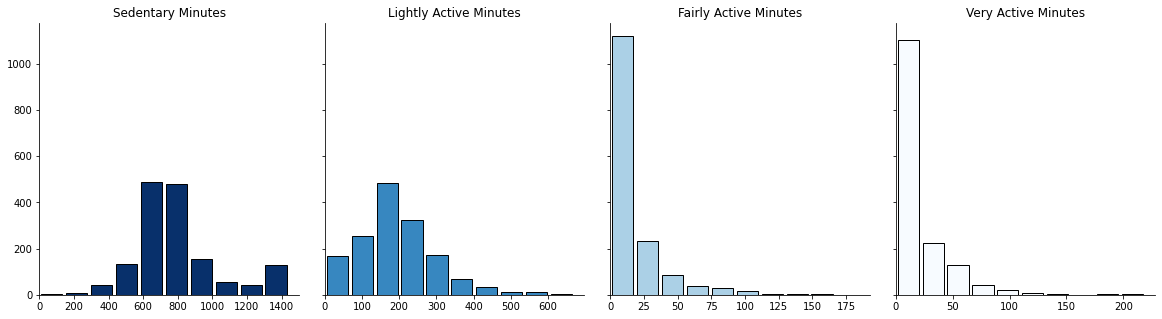

In [167]:
pp.plot_hist(merged[["sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"]])

<div class="alert alert-block alert-info">
    
Overall we can see that our participants tend to have very low amounts of `fairly_active` and `very_active` minutes.
    
</div>

## Clustering by Activity Level
We can use guidelines developed by the American College of Sports Medicine (ACSM) to determine low versus high activity nights. ACSM states that adults should do:
* Moderate Intensity: 150 - 300 minutes per week, or
* Vigorous: 75 - 150 minutes per week, or
* Combination

Fitbit divides activity level into multiple categories. While the cutoff points are not very clear, they are most likely:
* Sedentary: MET < 1
* Light: MET < 3
* Fairly: MET < 6
* Very: > 6

Regardless, we can try including various components of the activity metrics to see if they change the results.

In [168]:
from src.analysis import activity_and_sleep
act = activity_and_sleep.activity()

### Activity by Week
The guidelines are really _per week_ so perhaps we can include a rolling average of 7 days per participant to get at the true guideline.

In [169]:
weekly = act.get_active_minutes_per_week(merged,index_col="activity_date",id_col="beiwe")

With the rolling averages column, we now can include columns to see if the recommendations were met just like before.

In [170]:
levels = ["moderately","combined","vigorously"]
thresholds = [150,150,75]
for level, threshold in zip(levels, thresholds):
    act.add_guidelines_met(weekly,level,threshold)

<a id="analysis"></a>

# Analyzing Relationships

## Activity and Sleep (Aggregate)
The meat-and-potatoes of our analylsis, we can see if any of the activity categories we developed show clear differences in sleep metrics.

### Violin
Rather than look for relationships within the scatter plots, we can instead see if there are any differences in the distributions of sleep metrics for these categories.

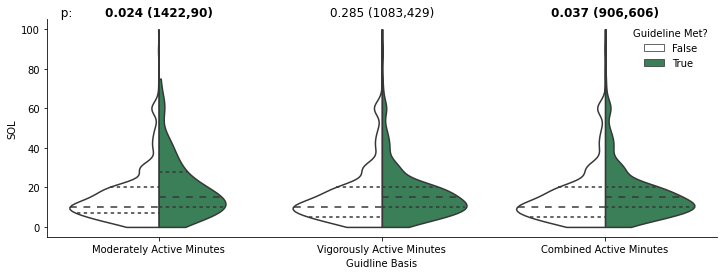

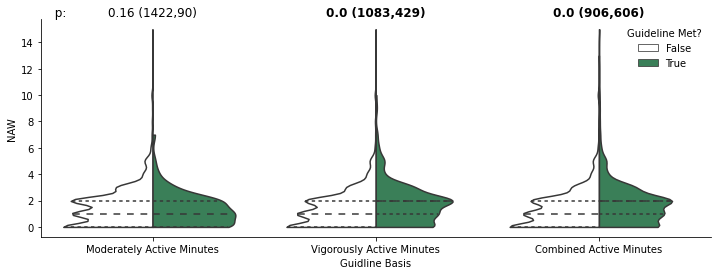

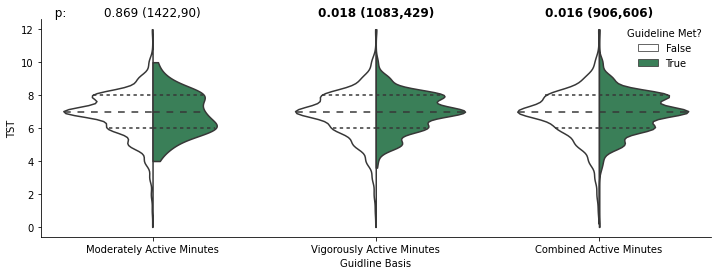

In [173]:
act.plot_violins(weekly,sleep_metrics=["sol","naw","tst"], annotate=True, save=True, save_dir="../reports/figures/ema_fitbit")

## Activity and Sleep (Individual)
Perhaps if we look on an individual level, we can get a better sense of the relationship that we should be seeing.

In [174]:
print("Number of Participants:", len(weekly["beiwe"].unique()))

Number of Participants: 46


In [176]:
def get_cleaned_activity_df(df, activity_level, sleep_metric, order=1, id_col="redcap", min_points=3):
    """
    Removes participants from dataframe and orders according to a given column
    """
    df_cleaned = pd.DataFrame()
    for pt in df[id_col].unique():
        df_by_pt = df[df[id_col] == pt]
        if len(df_by_pt) >= 7:
            df_by_pt_no_zeros = df_by_pt[df_by_pt[f"{activity_level}_active_minutes"] > 0]
            if len(df_by_pt_no_zeros) >= min_points:
                df_by_pt_no_zeros["n"] = len(df_by_pt_no_zeros)
                df_by_pt_no_zeros["slope"] = np.polyfit(df_by_pt_no_zeros[f"{activity_level}_active_minutes"],df_by_pt_no_zeros[sleep_metric],deg=order)[0]
                df_by_pt_no_zeros["r"] = abs(np.polyfit(df_by_pt_no_zeros[f"{activity_level}_active_minutes"],df_by_pt_no_zeros[sleep_metric],deg=order,full=True)[1][0])
                df_cleaned = df_cleaned.append(df_by_pt_no_zeros)
                
    return df_cleaned.sort_values("r",ascending=True)

In [179]:
def plot_indvidual_responses(df, sleep_metrics = ["rem_percent","wake_percent","nrem_percent","rem2nrem_percent","efficiency","tst_fb"]):
    for sleep_metric in sleep_metrics:
        for activity_level in ["moderately","combined","vigorously"]:
            df_to_plot = get_cleaned_activity_df(df,activity_level,sleep_metric)
            fig, axes = plt.subplots(4,11,figsize=(22,8),sharey=True,sharex=True,gridspec_kw={"wspace":0,"hspace":0})
            for pt, ax in zip(df_to_plot["redcap"].unique(),axes.flat):
                df_to_plot_by_pt = df_to_plot[df_to_plot["redcap"] == pt]
                sns.regplot(x=f"{activity_level}_active_minutes",y=sleep_metric,data=df_to_plot_by_pt,ci=None,truncate=True,order=1,
                            scatter_kws={"s": 20, "alpha":0.7,"color":"cornflowerblue"},
                            line_kws={"linewidth":1,"color":"black"},ax=ax)
                ax.set_xlabel("")
                ax.set_ylabel("")
                ax.set_title(int(pt),y=1.0)

                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

            fig.text(0.1,0.5,sleep_metric.replace("_"," ").replace("2",":").title(), ha='center', va='center', rotation='vertical',size=16)
            fig.text(0.5, 0.07, f"{activity_level.title()} Active Minutes per Day", ha='center', va='center',size=16)

            axes[3,0].get_xaxis().set_visible(True)
            axes[3,0].get_yaxis().set_visible(True)
            plt.show()
            plt.close()

In [180]:
plot_indvidual_responses(weekly, sleep_metrics="restful")

KeyError: 'r'